# INSTALL DEPENDENCIES

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [68]:
colorImgBgr = cv2.imread(r'../../Downloads/download.png')
grayImg = cv2.imread(r'../../Downloads/puppy.jpeg', cv2.IMREAD_GRAYSCALE)
grayAlb = cv2.imread(r'../../Downloads/albert-einstein_gray.jpg', cv2.IMREAD_GRAYSCALE)

In [69]:
import matplotlib as mpl
def displayImageInActualSize(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    plt.show

def displayImageInActualSizeColor(img):
    dpi = mpl.rcParams['figure.dpi']
    H, W = img.shape[0:2]
    figSize = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(img)
    plt.show

# BILINEAR TRANSFORMATION

In [70]:
def f_bilinearInterpolate(row, col, I):
    leftCol = int(col)
    rightCol = leftCol + 1
    widthLeft = col - leftCol
    widthRight = rightCol - col
    topRow = int(row)
    bottomRow = topRow + 1
    widthTop = row - topRow
    widthBottom = bottomRow - row
    if topRow >= 0 and bottomRow < I.shape[0] and leftCol >= 0 and rightCol < I.shape[1]:
        a = I[topRow, leftCol] * widthRight + I[topRow, rightCol] * widthLeft
        b = I[bottomRow, leftCol] * widthRight + I[bottomRow, rightCol] * widthLeft
        g = widthTop * b + widthBottom * a
        return np.uint8(g)
    else:
        return 0

# ROTATION IMPLEMENTATION

In [71]:
def f_getExtents(T, rMax, cMax):
    coords = np.array([[0,0], [0, cMax - 1], [rMax - 1, 0], [rMax - 1, cMax -1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [72]:
def f_transform(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtents(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

# AFFINE TRANSFORMATION

In [274]:
def f_getExtentsAffine(T, rMax, cMax):
    coords = np.array([[0,0, 1], [0, cMax - 1, 1], [rMax - 1, 0, 1], [rMax - 1, cMax -1, 1]])
    A_dash = T.dot(coords.T)
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H, W = maxR - minR + 1, maxC - minC + 1
    return minR, minC, maxR, maxC, H, W

In [275]:
def f_transformAffine(T, grayImg):
    rMax, cMax = grayImg.shape[0], grayImg.shape[1]
    minR, minC, maxR, maxC, H, W = f_getExtentsAffine(T, rMax, cMax)
    transformImg = np.ones((H, W), dtype='uint8')*255
    Tinv = np.linalg.inv(T)
    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i, new_j, 1])
            P = Tinv.dot(P_dash)
            i, j = P[0], P[1]
            if i<0 or i>=rMax or j<0 or j >= cMax:
               pass
            else:
               g = f_bilinearInterpolate(i, j, grayImg)
               transformImg[new_i - minR, new_j - minC] = g
    return transformImg

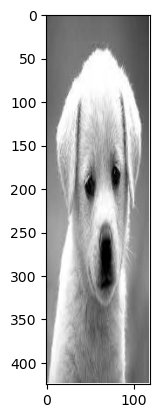

In [276]:
T = np.array([[2, 0, 10],[0, 0.5, 20],[0, 0, 1]])
img = f_transformAffine(T, grayImg)
plt.imshow(img, cmap='gray')

## Rotation in the new center

In [329]:
degree = 45
cosA = np.cos(np.deg2rad(degree))
sinA = np.sin(np.deg2rad(degree))
R = np.array([[cosA, -sinA, 0],[sinA, cosA, 0],[0, 0, 1]])
T = np.array([[1, 0, -300],[0, 1, -400],[0, 0, 1]])
A = np.linalg.inv(T).dot(R).dot(T)
A

array([[  0.70710678,  -0.70710678, 370.71067812],
       [  0.70710678,   0.70710678, -94.97474683],
       [  0.        ,   0.        ,   1.        ]])

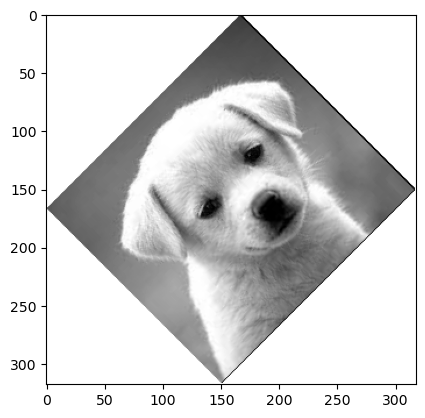

In [330]:
img = f_transformAffine(A, grayImg)
plt.imshow(img, cmap='gray')

In [331]:
a = 45
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))
R = np.array([[ca,-sa,0],[sa,ca,0],[0,0,1]])
T = np.array([[1,0,-300],[0,1,-400],[0,0,1]])
Sh = np.array([[1,0.5,0],[0,1,0],[0,0,1]])
S = np.array([[1.3,0,0],[0,0.7,0],[0,0,1]])
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)

In [332]:
A

array([[  0.91923882,  -0.45961941, 208.07611845],
       [  0.49497475,   0.74246212, -45.47727215],
       [  0.        ,   0.        ,   1.        ]])

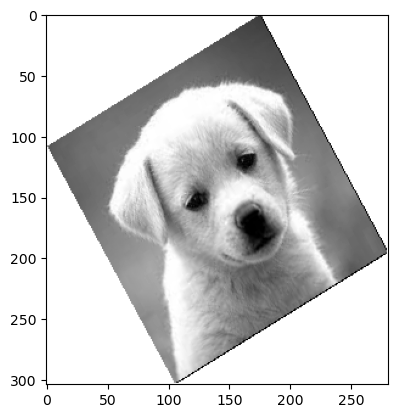

In [333]:
I2 = f_transformAffine(A,grayImg)
plt.imshow(I2,cmap='gray')

## REFLECTION ABOUT A LINE 